# Trials for KFAC
## Generic setup (~~regression~~ binary classification task)

In [1]:
using Pkg
Pkg.activate(".")
using LaplaceRedux
using LaplaceRedux.Curvature
using LaplaceRedux.Data
using Flux
using Flux.Optimise: update!, Adam
using Plots
using Statistics
using MLUtils
using Zygote

using Printf
using NNlib
using BenchmarkTools
using Tullio
using PrettyPrinting
using LinearAlgebra
using Colors, Plots

  Activating new project at `~/Builds/navimakarov/LaplaceRedux.jl/dev/notebooks/KFAC/sb`


In [2]:
# Init data
n = 2000
data_dict = Dict()
# bsize = 10
# ommit bsizes for now

# x, y = LaplaceRedux.Data.toy_data_regression(n)
# xs = [[x] for x in x]
# X, Y = reduce(hcat, x), reduce(hcat, y)

# # dataloader = DataLoader((X, Y), batchsize=bsize)
# data = zip(xs, y)
# data_dict[:regression] = Dict(
#     :data => data,
#     :X => X,
#     :y => y,
#     :outdim => 1,
#     :loss_fun => :mse,
#     :likelihood => :regression,
# )

# Classification binary:
xs, y = LaplaceRedux.Data.toy_data_non_linear(n)
X = reduce(hcat, xs)
Y = reduce(hcat, y)
data = zip(xs, y)
data_dict[:classification_binary] = Dict(
    :data => data,
    :X => X,
    :Y => Y,
    :y => y,
    :outdim => 1,
    :loss_fun => :logitbinarycrossentropy,
    :likelihood => :classification,
)



Dict{Symbol, Any} with 7 entries:
  :loss_fun   => :logitbinarycrossentropy
  :y          => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0…
  :likelihood => :classification
  :X          => [2.80305 1.19347 … -2.07931 -3.26323; 3.24384 2.39091 … 3.3348…
  :Y          => [1.0 1.0 … 0.0 0.0]
  :outdim     => 1
  :data       => zip([[2.80305, 3.24384], [1.19347, 2.39091], [4.27973, 4.7876]…

In [3]:
# Train a NN model

val = data_dict[:classification_binary]

# Unpack:
data = val[:data]
X = val[:X]
y = val[:y]
outdim = val[:outdim]
loss_fun = val[:loss_fun]
likelihood = val[:likelihood]

# Neural network:
n_hidden = 32
D = size(X, 1)
nn = Chain(Dense(D, n_hidden, σ), Dense(n_hidden, outdim))
λ = 0.01
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1 / 2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = getfield(Flux.Losses, loss_fun)(nn(x), y) + weight_regularization()


opt = Adam()
epochs = 200
avg_loss(data) = mean(map(d -> loss(d[1], d[2]), data))
show_every = epochs / 10

for epoch in 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

H_facs = nothing

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 32, σ)   # 96 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


Epoch 20
avg_loss(data) = 0.2865965417020954
Epoch 40
avg_loss(data) = 0.09509227910829936
Epoch 60
avg_loss(data) = 0.07713148846552068
Epoch 80
avg_loss(data) = 0.07278975016174948
Epoch 100
avg_loss(data) = 0.07114890917363521
Epoch 120
avg_loss(data) = 0.07041154312993458
Epoch 140
avg_loss(data) = 0.06998371414254066
Epoch 160
avg_loss(data) = 0.06969246734235789
Epoch 180
avg_loss(data) = 0.06947445884993358
Epoch 200
avg_loss(data) = 0.06929677478314257


In [4]:
# Take one datapoint of the dataset
x_1 = xs[1]
y_1 = y[1]

1.0

## KFAC Fisher

In [31]:
# todo: obtain the kronecker factors approximating the hessian for the first datapoint for the first layer

# References.
# https://towardsdatascience.com/introducing-k-fac-and-its-application-for-large-scale-deep-learning-4e3f9b443414
# Daxberger et al.
# Martens & Grosse

a = Flux.activations(nn, x_1)
acts = a

(Float32[0.00071874616, 0.00016742604, 0.87883204, 0.00068176794, 0.9698986, 0.000117275755, 0.94732326, 0.086328626, 0.00010406953, 0.023307256  …  1.6348773f-5, 0.0029512192, 5.905252f-5, 0.00018570888, 4.424152f-5, 0.00015386227, 0.8745206, 5.9462036f-5, 7.955101f-5, 0.00019166034], Float32[5.952421])

In [12]:
yhat_1 = nn(x_1)

1-element Vector{Float32}:
 5.952421

In [30]:
yhat_1 == a[2]

true

In [15]:
foreach(x -> (@show size(x)), acts)

size(x) = (32,)
size(x) = (1,)


In [22]:
loss_m = m -> Flux.Losses.logitbinarycrossentropy(m(x_1), y_1)
grads = gradient(loss_m, nn)[1]

(layers = ((weight = Float32[-7.850426f-6 -6.921907f-6; 4.4020385f-6 3.8813814f-6; … ; -1.8888776f-6 -1.6654681f-6; 3.8544867f-6 3.3985918f-6], bias = Float32[-1.5766433f-6, 8.84085f-7, -0.000361299, -1.6891946f-6, -0.00010785097, 5.020244f-7, -0.00018720127, -0.00047395955, -4.6244327f-7, 0.00023837869  …  -4.906786f-8, 1.682414f-5, -3.020611f-7, 7.5977243f-7, -2.407904f-7, 8.194232f-7, -0.00037449668, 3.3323127f-7, -3.7935342f-7, 7.741172f-7], σ = nothing), (weight = Float32[-1.863564f-6 -4.34102f-7 … -2.0625976f-7 -4.9693665f-7], bias = Float32[-0.0025927986], σ = nothing)),)

In [39]:
W = Any[nothing, nothing]
g = Any[nothing, nothing]

2-element Vector{Any}:
 nothing
 nothing

In [42]:
W[1] = grads.layers[1].weight
W[2] = grads.layers[2].weight
W[1]

32×2 Matrix{Float32}:
 -7.85043f-6   -6.92191f-6
  4.40204f-6    3.88138f-6
 -0.00179898   -0.0015862
 -8.41084f-6   -7.41604f-6
 -0.000537012  -0.000473496
  2.49968f-6    2.20403f-6
 -0.000932113  -0.000821866
 -0.00235994   -0.00208082
 -2.3026f-6    -2.03026f-6
  0.00118694    0.00104655
 -1.41018f-6   -1.24339f-6
 -1.18624f-6   -1.04594f-6
  9.17759f-5    8.0921f-5
  ⋮            
 -9.45684f-6   -8.33832f-6
  0.0132107     0.0116482
 -2.44319f-7   -2.15422f-7
  8.37708f-5    7.38627f-5
 -1.50402f-6   -1.32613f-6
  3.78306f-6    3.33561f-6
 -1.19894f-6   -1.05714f-6
  4.08007f-6    3.5975f-6
 -0.00186469   -0.00164415
  1.65923f-6    1.46298f-6
 -1.88888f-6   -1.66547f-6
  3.85449f-6    3.39859f-6

In [43]:
pinv(a[1])

1×32 transpose(::Vector{Float32}) with eltype Float32:
 0.000130664  3.04371f-5  0.159767  …  1.08099f-5  1.44619f-5  3.48427f-5

In [46]:
pinv(a[1]) * a[1]

1.0000002f0

In [50]:
g[1] = grads.layers[1].weight * pinv(x_1')

32-element Vector{Float64}:
 -1.576643303712004e-6
  8.840850297488131e-7
 -0.0003612990100679568
 -1.6891946298849152e-6
 -0.00010785096801257645
  5.02024426779488e-7
 -0.00018720126588310092
 -0.0004739595477057084
 -4.6244328219434377e-7
  0.00023837869781410552
 -2.832142629629221e-7
 -2.3823991529586152e-7
  1.8431845650675716e-5
  ⋮
 -1.8992675064377666e-6
  0.0026531709389373886
 -4.906786288557403e-8
  1.6824140754190347e-5
 -3.0206109810569945e-7
  7.597724517642064e-7
 -2.4079040231335137e-7
  8.194232093232953e-7
 -0.00037449668775830396
  3.3323128283762444e-7
 -3.793534335116664e-7
  7.741172480427405e-7

In [51]:
g[2] = grads.layers[2].weight * pinv(a[1]')

1-element Vector{Float32}:
 -0.002592799

In [54]:
isapprox(W[2], g[2] * a[1]')

true

In [55]:
A = Any[nothing, nothing]
G = Any[nothing, nothing]

2-element Vector{Any}:
 nothing
 nothing

In [64]:
A_0 = x_1 * x_1'
A[1] = a[1] * a[1]'
# A[2] = a[2] * a[2]'
G[1] = g[1] * g[1]'
G[2] = g[2] * g[2]'

1×1 Matrix{Float32}:
 6.722607f-6

In [65]:
A_0

2×2 Matrix{Float64}:
 24.7925  21.8601
 21.8601  19.2746

In [66]:
G[1]

32×32 Matrix{Float64}:
  2.4858e-12   -1.39389e-12   5.6964e-10   …   5.98105e-13  -1.22051e-12
 -1.39389e-12   7.81606e-13  -3.19419e-10     -3.35381e-13   6.84385e-13
  5.6964e-10   -3.19419e-10   1.30537e-7       1.3706e-10   -2.79688e-10
  2.66326e-12  -1.49339e-12   6.10304e-10      6.40802e-13  -1.30763e-12
  1.70043e-10  -9.53494e-11   3.89664e-8       4.09136e-11  -8.34893e-11
 -7.91513e-13   4.43832e-13  -1.81381e-10  …  -1.90445e-13   3.88626e-13
  2.9515e-10   -1.65502e-10   6.76356e-8       7.10154e-11  -1.44916e-10
  7.47265e-10  -4.19021e-10   1.71241e-7       1.79798e-10  -3.669e-10
  7.29108e-13  -4.08839e-13   1.6708e-10       1.75429e-13  -3.57985e-13
 -3.75838e-10   2.10747e-10  -8.6126e-8       -9.04298e-11   1.84533e-10
  4.46528e-13  -2.50385e-13   1.02325e-10  …   1.07438e-13  -2.19241e-13
  3.75619e-13  -2.10624e-13   8.60758e-11      9.03771e-14  -1.84426e-13
 -2.90604e-11   1.62953e-11  -6.65941e-9      -6.99218e-12   1.42684e-11
  ⋮                           

In [67]:
A[1]

32×32 Matrix{Float32}:
 5.16596f-7   1.20337f-7   0.000631657  …  5.7177f-8   1.37755f-7
 1.20337f-7   2.80315f-8   0.000147139     1.33189f-8  3.20889f-8
 0.000631657  0.000147139  0.772346        6.9912f-5   0.000168437
 4.90018f-7   1.14146f-7   0.00059916      5.42353f-8  1.30668f-7
 0.000697111  0.000162386  0.852378        7.71564f-5  0.000185891
 8.42915f-8   1.9635f-8    0.000103066  …  9.3294f-9   2.24771f-8
 0.000680885  0.000158607  0.832538        7.53605f-5  0.000181564
 6.20484f-5   1.44537f-5   0.0758684       6.86753f-6  1.65458f-5
 7.47996f-8   1.74239f-8   9.14596f-5      8.27884f-9  1.9946f-8
 1.6752f-5    3.90224f-6   0.0204832       1.85412f-6  4.46708f-6
 3.90706f-8   9.10117f-9   4.77727f-5   …  4.32434f-9  1.04185f-8
 3.13771f-8   7.30904f-9   3.83657f-5      3.47283f-9  8.367f-9
 2.85372f-6   6.64752f-7   0.00348933      3.15851f-7  7.60972f-7
 ⋮                                      ⋱  ⋮           
 5.76817f-7   1.34365f-7   0.000705291  …  6.38422f-8  1.53814f

In [68]:
G[2]

1×1 Matrix{Float32}:
 6.722607f-6

In [70]:
K = Kron([(A[1], G[1]), (A[2], G[2])])

Kron1(Tuple{AbstractArray, AbstractArray}[(Float32[5.1659606f-7 1.2033682f-7 … 5.7176987f-8 1.3775514f-7; 1.2033682f-7 2.803148f-8 … 1.3318911f-8 3.208893f-8; … ; 5.7176987f-8 1.3318911f-8 … 6.3283636f-9 1.5246775f-8; 1.3775514f-7 3.208893f-8 … 1.5246775f-8 3.6733685f-8], [2.4858041071399025e-12 -1.393886742065494e-12 … 5.981050506863257e-13 -1.2205067754145511e-12; -1.393886742065494e-12 7.816063398259596e-13 … -3.3538069155147594e-13 6.843854702649355e-13; … ; 5.981050506863257e-13 -3.3538069155147594e-13 … 1.439090275170903e-13 -2.936640359856159e-13; -1.2205067754145511e-12 6.843854702649355e-13 … -2.936640359856159e-13 5.992575137172657e-13]), (Float32[35.431316;;], Float32[6.722607f-6;;])])

In [71]:
K_1 = kron(A[1], G[1])

1024×1024 Matrix{Float64}:
  1.28416e-18  -7.20076e-19   2.94274e-16  …   8.2392e-20   -1.68131e-19
 -7.20076e-19   4.03775e-19  -1.65011e-16     -4.62004e-20   9.42776e-20
  2.94274e-16  -1.65011e-16   6.74349e-14      1.88807e-17  -3.85284e-17
  1.37583e-18  -7.7148e-19    3.15281e-16      8.82737e-20  -1.80133e-19
  8.78433e-17  -4.92571e-17   2.01299e-14      5.63606e-18  -1.15011e-17
 -4.08893e-19   2.29282e-19  -9.37007e-17  …  -2.62347e-20   5.35352e-20
  1.52473e-16  -8.54976e-17   3.49403e-14      9.78274e-18  -1.99629e-17
  3.86034e-16  -2.16464e-16   8.84625e-14      2.47681e-17  -5.05424e-17
  3.76654e-19  -2.11205e-19   8.6313e-17       2.41663e-20  -4.93143e-20
 -1.94157e-16   1.08871e-16  -4.44923e-14     -1.24572e-17   2.54204e-17
  2.30675e-19  -1.29348e-19   5.28607e-17  …   1.48002e-20  -3.02016e-20
  1.94043e-19  -1.08808e-19   4.44664e-17      1.24499e-20  -2.54056e-20
 -1.50125e-17   8.4181e-18   -3.44022e-15     -9.63209e-19   1.96555e-18
  ⋮                     

## Exact Hessian of a Neural Network Loss

In [10]:
Y = reduce(hcat, y)

1×2000 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [13]:
# https://fluxml.ai/Flux.jl/stable/destructure/
model = nn
theta, rebuild = Flux.destructure(model)

function lossv(theta::Vector)
    m = rebuild(theta)
    Flux.Losses.logitbinarycrossentropy(m(X), Y)
end;

H = Zygote.hessian(lossv, theta)

129×129 Matrix{Float64}:
  0.00271913   -0.00193202    0.00371712   …  -0.00198667    0.000285266
 -0.00193202    0.0817749    -0.0114599        0.0174484     0.0167375
  0.00371712   -0.0114599     0.034458        -0.00686917   -0.00386988
  0.00421892   -0.00243919    0.00556817      -0.00251798    0.000544568
  0.000546065  -0.00209699    0.00123145      -0.00296098   -0.00335194
 -0.00188388    0.0477259    -0.0118999    …   0.0175487     0.0168614
 -0.00195094    0.000868155  -0.00272431      -0.000661658  -0.00310791
  0.00449002   -0.003273      0.00717346      -0.00323809    0.000144622
 -0.00191828    0.00107901   -0.00253908      -0.000636679  -0.00325628
  0.00161127   -0.000854767   0.00104656      -0.00135239   -0.000361344
  0.000949631  -0.0149923     0.00452312   …  -0.00906646   -0.00984472
  0.00153462   -0.00078873    0.000910314     -0.00133789   -0.000391755
 -0.00199972    0.00108988   -0.00264861      -0.000683867  -0.00341702
  ⋮                                 

In [12]:
nn(X)

1×2000 Matrix{Float32}:
 7.33397  4.74386  5.63692  6.08972  3.42295  …  -7.78776  -9.24977  -9.13133

In [15]:
function norm_abs(H)
    H_abs = broadcast(abs, H)
    H_abs ./ findmax(H_abs)[1]
end

function flip(H)
    H[end:-1:1, :]
end

grayplot(H) = plot(Gray.(norm_abs(H)))

function colplot(H)
    lim, = findmax(abs, H)
    heatmap(flip(H), color=:berlin, ratio=:equal, clims=(-lim, lim))
end

colplot (generic function with 1 method)

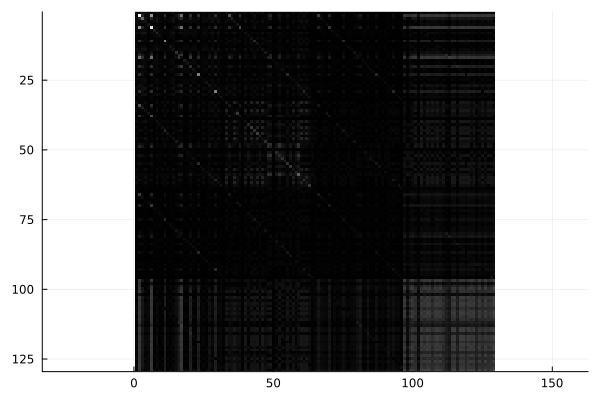

In [16]:
grayplot(H)

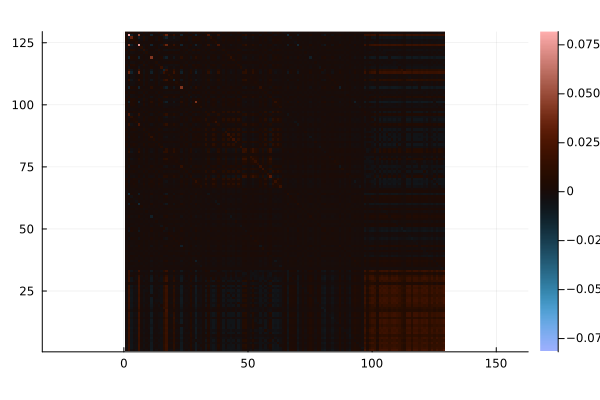

In [17]:
colplot(H)

In [83]:
flat(grads::Zygote.Grads) = reduce(vcat, [vec(grads[t]) for t in grads.params])

flat (generic function with 1 method)

## Fisher Information

In [18]:
# Compute the Fisher for x_1, theta
# Note: y_1, the training label is not used here.

F = zeros(129, 129)

for i in 1:length(y)
    p_1 = sigmoid(nn(xs[i]))
    p_0 = 1 .- p_1

    g_w_y_1, = Flux.destructure(gradient(m -> Flux.Losses.logitbinarycrossentropy(m(xs[i]), 1), nn))
    g_w_y_0, = Flux.destructure(gradient(m -> Flux.Losses.logitbinarycrossentropy(m(xs[i]), 0), nn))

    g_expd = p_1 .* g_w_y_1 + p_0 .* g_w_y_0

    F += g_expd * g_expd'
end


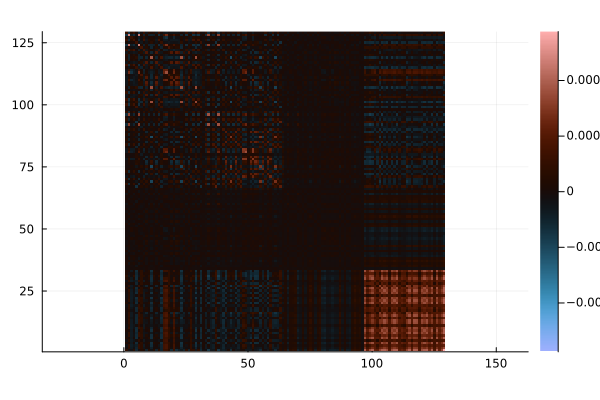

In [19]:
colplot(F)

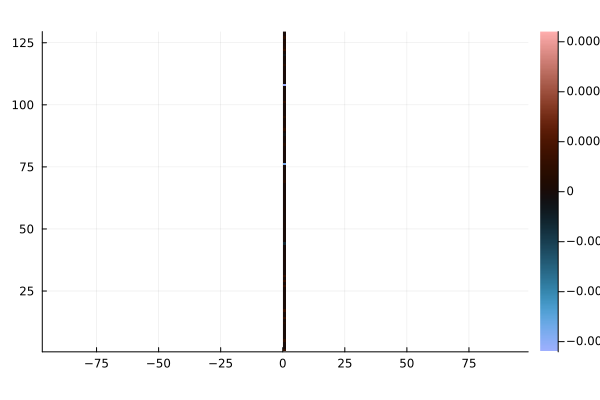

In [105]:
colplot(g_expd)

## Kron

In [69]:
mutable struct Kron1
#    kfacs :: Union{Vector{Tuple{AbstractArray, AbstractArray}},Vector{Matrix},Nothing}
    kfacs :: Vector{Tuple{AbstractArray, AbstractArray}}
end

Kron = Kron1
    
# mutable struct KronDecomposed
#     eigenvectors :: Union{AbstractArray,Nothing}
#     eigenvalues :: Union{AbstractArray,Nothing}
#     damping :: Bool
# end


Kron1

### Addition

In [17]:
import Base: +, ==, *

function (+)(l::Kron, r::Kron)
    @assert length(l.kfacs) == length(r.kfacs)
    kfacs = [Tuple(Hi + Hj for (Hi, Hj) in zip(Fi, Fj))
                for (Fi, Fj) in zip(l.kfacs, r.kfacs)]
    return Kron(kfacs)
end

function (==)(l::Kron, r::Kron)
    return l.kfacs == r.kfacs
end

# H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
#        kfacs = [[Hi.add(Hj) for Hi, Hj in zip(Fi, Fj)]
#                 for Fi, Fj in zip(self.kfacs, other.kfacs)]

== (generic function with 185 methods)

### Tests

In [9]:
using Test

In [10]:
left = Kron([([1 2], [3 4])])
right = Kron([([5 6], [7 8])])
total = left + right
@test total.kfacs == [([6 8], [10 12])]

Test Passed

In [16]:
left = Kron([([1 2], [3 4]), ([11 12], [13 14])])
right = Kron([([5 6], [7 8]), ([15 16], [17 18])])
total = left + right
@test total.kfacs == [([6 8], [10 12]), ([26 28], [30 32])]

Test Passed

In [13]:
left = Kron([])
total = left + left
@test total == left

Test Passed

In [15]:
left = Kron([([1 2], [3 4]), ([], [])])
right = Kron([([5 6], [7 8])])
@test_throws AssertionError left + right

Test Passed
      Thrown: AssertionError

In [8]:
collect(zip([1, 2, 3], [4, 5, 6, 7]))

3-element Vector{Tuple{Int64, Int64}}:
 (1, 4)
 (2, 5)
 (3, 6)

### Scaling

In [31]:
function (*)(l::Real, r::Kron)
        kfacs = [Tuple(^(l, 1/length(F)) * Hi for Hi in F) for F in r.kfacs]
        return Kron(kfacs)
end

(*)(l::Kron, r::Real) = (*)(r, l)

* (generic function with 311 methods)

### Tests

In [38]:
left = 4
right = Kron([([5 6], [7 8])])
@test left * right == right * left
@test (left * right).kfacs == [([10 12], [14 16])]

Test Passed

## Andrei's code

In [7]:
function init(model)
    kfacs = []

    for p in Flux.params(model)
        if ndims(p) == 1  # bias
            P = size(p, 1)
            push!(kfacs, [zeros(P, P)])
        elseif 4 >= ndims(p) >= 2  # fully connected or conv
            if ndims(p) == 2  # fully connected
                P_in, P_out = size(p)
            elseif ndims(p) > 2
                P_in, P_out = size(p, 1), prod(size(p)[2:end])
            end
            
            push!(kfacs, [
                zeros(P_in, P_in),
                zeros(P_out, P_out)
            ])
        else
            error("Invalid parameter shape in network.")
        end
    end
    # @show kfacs
    # @show get_array_sizes(kfacs)
    # @show print_arrays(kfacs)
    return Kron(kfacs)
end

init (generic function with 1 method)

In [8]:
function fitBeta(la::Laplace, data; batched::Bool=false, batchsize::Int, override::Bool=true)
    if override
        H = init(la.model)          
        loss = 0.0
        n_data = 0
    end

    # Training:
    for d in data
        x, y = d
        loss_batch, H_batch =_curv_closure(la.curvature, x, y, length(data))
        loss += loss_batch
        @show(H_batch)
        @show(H)
        H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
        n_data += batchsize
    end

    # Store output:
    la.loss = loss                                                           # Loss
    la.H = H                                                                 # Hessian
    la.P = posterior_precision(la)                                           # posterior precision
    la.Σ = posterior_covariance(la)                                          # posterior covariance
    return la.n_data = n_data                                                # number of observations
end

fitBeta (generic function with 1 method)

In [45]:
# fitting kron
function fitAux(la, train_loader, override=true, damping=false)
    if override
        H_facs = nothing
    end

    if !isnothing(H_facs)
        n_data_old = la.n_data
        n_data_new = length(train_loader)
        la.H = init(la.model) # re-init H non-decomposed
        # discount previous Kronecker factors to sum up properly together with new ones
        H_facs = _rescale_factors(H_facs, n_data_old / (n_data_old + n_data_new))
    end

    fitBeta(la, train_loader, batched=false, batchsize=1, override=override)

    if isnothing(H_facs)
        H_facs =la.H
    else
        # discount new factors that were computed assuming N = n_data_new
        la.H = _rescale_factors(la.H, n_data_new / (n_data_new + n_data_old))
        H_facs += la.H
    end
    # Decompose to self.H for all required quantities but keep H_facs for further inference
    la.H = decompose(la.H_facs, damping=damping)
end

fitAux (generic function with 3 methods)

In [46]:
function _curv_closure(curvature, x, y, N)
    return kron(curvature, x, y, N) #la.backend.kron(X, y, N=N)
end

_curv_closure (generic function with 1 method)

In [47]:
function posterior_precision(la::Laplace, H=la.H, P₀=la.P₀)
    @assert !isnothing(H) "Hessian not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return H .+ P₀
end

posterior_precision (generic function with 3 methods)

In [48]:
function posterior_covariance(la::Laplace, P=posterior_precision(la))
    @assert !isnothing(P) "Posterior precision not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return inv(P)
end

posterior_covariance (generic function with 2 methods)

In [49]:
function kron(curvature, x, y, N)
    #context = ifelse(self.stochastic, KFAC, KFLR)
    loss = curvature.factor * curvature.loss_fun(x, y)
    𝐠 = gradient(() -> curvature.loss_fun(x, y), Flux.params(curvature.model))
    𝐠 = reduce(vcat, [vec(𝐠[i]') for i in curvature.params])  
    # backpack(context()) do
    #     backward(loss)
    # end
    kron = Kron(𝐠)
    @show(kron)
    kron = _rescale_kron_factors(kron, length(y), N)
    return curvature.factor * loss, kron#curvature.factor * detach(loss), curvature.factor * kron
end

kron (generic function with 1 method)

In [50]:
function decompose(kron,damping=false)
    """
    Eigendecompose Kronecker factors and turn into `KronDecomposed`.
    
    Parameters
    ----------
    damping : bool
        use damping

    Returns
    -------
    kron_decomposed : KronDecomposed
    """
    eigvecs = []
    eigvals = []
    for F in kron.kfacs
        Qs = []
        ls = []
        for Hi in F
            l, Q = symeig(Hi)
            push!(Qs, Q)
            push!(ls, l)
        push!(eigvecs, Qs)
        push!(eigvals, ls)
        end
    end
    return KronDecomposed(eigvecs, eigvals, damping=damping)
end

decompose (generic function with 2 methods)

In [51]:
function _rescale_factors(kron, factor)
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= factor
        end
    end
    return kron
end

_rescale_factors (generic function with 1 method)

In [52]:
function _rescale_kron_factors(kron, M, N)
    # Renormalize Kronecker factor to sum up correctly over N data points with batches of M
    # for M=N (full-batch) just M/N=1
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= M/N
        end
    end
    return kron
end

_rescale_kron_factors (generic function with 1 method)

In [7]:
function _get_kron_factors(la)
    return Kron([p.kfac for p la.model.parameters])
end

LoadError: syntax: invalid iteration specification

In [54]:
# dataloader = DataLoader((X, Y), batchsize=10)

200-element DataLoader(::Tuple{Matrix{Float64}, Matrix{Float64}}, batchsize=10)
  with first element:
  (1×10 Matrix{Float64}, 1×10 Matrix{Float64},)

In [55]:
# function fit_la(nn, dataloader, X, y)
#     la_b = Laplace(nn; likelihood=:regression, λ=λ, subset_of_weights=:all)
#     fitAux(la_b, dataloader)
#     plot(la_b, X, y )
# end

fit_la (generic function with 1 method)

In [6]:
# fit_la(nn, dataloader, X, y)